In [100]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt

In [101]:
# Synthetic data
N = 1000
series = np.sin(0.1*np.arange(N)) + np.random.randn(N)*0.1

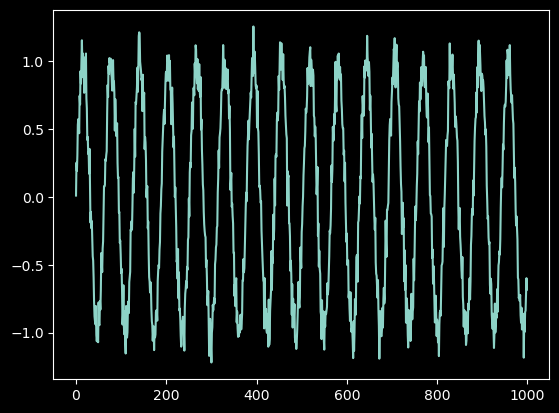

In [102]:
plt.plot(series)
plt.show()

In [103]:
# Some parameters for the RNN
T = 10  # Length of a window
D = 1  # How many features

In [104]:
class simpleRNN(nn.Module):
    """
    Predict the next observation given past observation
    """
    def __init__(self, num_features, num_outs, num_hiddens, device, num_layers=1, activation_func="relu"):
        super(simpleRNN, self).__init__()
        
        self.L = num_layers
        self.M = num_hiddens
        self.D = num_features
        self.K = num_outs
        self.device = device
        
        self.rnn = nn.RNN(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            nonlinearity=activation_func,
            batch_first=True,
        )
        
        self.dense = nn.Linear(self.M, self.K)
        
    def forward(self, X):
        # Initial hidden states
        h0 = torch.zeros(self.L, X.size(0), self.M).to(self.device)
        
        # Grab all hidden states for each time step of the LAST layer (NxTxM)
        out, _ = self.rnn(X, h0)
        
        out = self.dense(out[:, -1, :])  # Here, we care only about the last time step
        return out

In [105]:
num_epochs = 1000
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = simpleRNN(1, 1, 15, device, 1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [106]:
### build the dataset
# let's see if we can use T past values to predict the next value
T = 10
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)
N_size = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (990, 10, 1) Y.shape (990, 1)


In [107]:
# Reshape the data
X_train = torch.from_numpy(X[:-N_size//2].astype(np.float32)).to(device)
y_train = torch.from_numpy(Y[:-N_size//2].astype(np.float32)).to(device)
X_test = torch.from_numpy(X[-N_size//2:].astype(np.float32)).to(device)
y_test = torch.from_numpy(Y[-N_size//2:].astype(np.float32)).to(device)

In [108]:
# Train the model
loss_history = np.zeros(num_epochs)
test_history = np.zeros(num_epochs)
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # forward pass
    y_hat = model(X_train)
    loss = criterion(y_hat, y_train)
    
    loss_history[epoch] = loss.item()
    
    # Backward pass
    loss.backward()
    optimizer.step()
    
    # Test loss
    y_test_hat = model(X_test)
    test_loss = criterion(y_test_hat, y_test)
    test_history[epoch] = test_loss.item()
    
    print(f"Epoch {epoch}/{num_epochs}: train loss={loss.item()}")

Epoch 0/1000: train loss=0.6379214525222778
Epoch 1/1000: train loss=0.5604771971702576
Epoch 2/1000: train loss=0.5045083165168762
Epoch 3/1000: train loss=0.4615844190120697
Epoch 4/1000: train loss=0.4236542880535126
Epoch 5/1000: train loss=0.38701891899108887
Epoch 6/1000: train loss=0.35007691383361816
Epoch 7/1000: train loss=0.3135680556297302
Epoch 8/1000: train loss=0.274269163608551
Epoch 9/1000: train loss=0.2307693064212799
Epoch 10/1000: train loss=0.18807683885097504
Epoch 11/1000: train loss=0.15506431460380554
Epoch 12/1000: train loss=0.13914859294891357
Epoch 13/1000: train loss=0.12440741807222366
Epoch 14/1000: train loss=0.10009243339300156
Epoch 15/1000: train loss=0.08520320057868958
Epoch 16/1000: train loss=0.08938314020633698
Epoch 17/1000: train loss=0.09629973024129868
Epoch 18/1000: train loss=0.0902240201830864
Epoch 19/1000: train loss=0.07679162174463272
Epoch 20/1000: train loss=0.06686156988143921
Epoch 21/1000: train loss=0.061897940933704376
Epoch 2

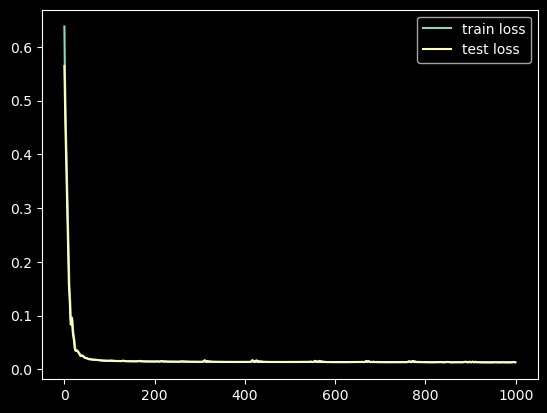

In [109]:
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

In [110]:
validation_target = Y[-N//2:]
validation_predictions = []

# last train input
# last_x = torch.from_numpy(X[-N//2]) # 1-D array of length T
# last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1, T, 1)
    p = model(input_)  # 1x1 array 
    
    # update the predictions list
    validation_predictions.append(p[0,0].item())
    
    # make the new input
    last_x = torch.cat((last_x[1:], p[0]))

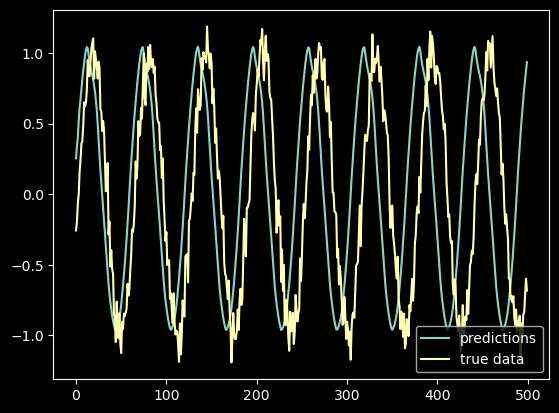

In [111]:
plt.plot(validation_predictions, label="predictions")
plt.plot(validation_target, label="true data")
plt.legend()
plt.show()